*This notebook shows the interleaving depth level changes as a step-wise function from 4 probes behind the DSL network.*
- - - 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
import sqlite3
import pandas as pd
import matplotlib.dates as dates

In [4]:
DB_LOCATION = 'lastmile.db'

In [5]:
RA_PROBE = 'ra_probe'
RA_PROBE_API = 'ra_probe_api'
RA_ASN = 'ra_asn'
RA_ONE_OFF_EXTENSIONS = 'ra_one_off_extensions'
RA_LATENCIES_AGG = 'ra_latencies_agg'

In [6]:
SK_ONE_OFF_EXTENSIONS = 'sk_one_off_extensions'
SK_LATENCIES_AGG = 'sk_latencies_agg'
SK_ASN = 'sk_asn'
METADATA_SNAPSHOT = 'metadata_snapshot'
METADATA_SNAPSHOT_EXTENSIONS = 'metadata_snapshot_extensions'

In [7]:
con = sqlite3.connect(DB_LOCATION)

In [8]:
query_ra = '''SELECT      agg.probeid
                        , agg.timestamp
                        , s.asn
                        , s.asn_holder_name
                        , s.asn_access_type
                        , agg.h1_median as h1
                        , agg.h2_median as h2                        

               FROM   %s                             as  agg
                    , %s                             as  api               
                    , %s                             as  s                  
                    , %s                             as  hardware
                    , %s                             as  ext

               WHERE     agg.probeid                  =  api.probeid
               AND       agg.probeid                  =  hardware.probeid
               AND       agg.probeid                  =  ext.probeid
               AND       api.asn_v4                   =  s.asn
               

               AND       hardware.hardware_version    =  'v3'
               AND       ext.if_residential           =  1
               
            '''%(  RA_LATENCIES_AGG
                 , RA_PROBE_API
                 , RA_ASN
                 , RA_PROBE
                 , RA_ONE_OFF_EXTENSIONS
                )

df_ra = pd.read_sql(query_ra, con)

In [9]:
df_ra.count()

probeid            134724
timestamp          134724
asn                134724
asn_holder_name    134724
asn_access_type    134724
h1                 133920
h2                 130563
dtype: int64

In [10]:
df_ra.head()

,probeid,timestamp,asn,asn_holder_name,asn_access_type,h1,h2
0,10006,1406548034,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,0.429,20.490
1,10006,1406562432,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,0.431,17.700
2,10006,1406576835,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,0.438,17.776
3,10006,1406591230,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,0.478,17.577
4,10006,1406605631,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,0.422,17.526


In [11]:
query_sk = ''' SELECT     agg.probeid
                        , agg.timestamp
                        , s.asn 
                        , s.asn_access_type
                        , s.asn_holder_name
                        , meta.product                        
                        , agg.h1_avg as h1
                        , agg.h2_avg as h2
                                                                                     
               FROM       %s                            as   agg
                        , %s                            as   api               
                        , %s                            as   ext
                        , %s                            as   s
                        , %s                            as   meta
                        
                        

               WHERE      agg.probeid                    =    ext.probeid
               AND        agg.probeid                    =    api.probeid
               AND        agg.probeid                    =    meta.id               
               AND        api.asn                        =    s.asn               
               
               AND        ext.if_residential             =    1
               AND        agg.h1_avg                     <>   0
               AND        agg.h2_avg                     <>   0
               
           '''%(   SK_LATENCIES_AGG
                 , METADATA_SNAPSHOT_EXTENSIONS                
                 , SK_ONE_OFF_EXTENSIONS
                 , SK_ASN        
                 , METADATA_SNAPSHOT                
               )

df_sk = pd.read_sql(query_sk, con)

In [12]:
df_ra = df_ra.dropna()

In [13]:
df_sk = df_sk.dropna()

In [14]:
df_sk.count()

probeid            415903
timestamp          415903
asn                415903
asn_access_type    415903
asn_holder_name    415903
product            415903
h1                 415903
h2                 415903
dtype: int64

In [15]:
df_ra.count()

probeid            130006
timestamp          130006
asn                130006
asn_holder_name    130006
asn_access_type    130006
h1                 130006
h2                 130006
dtype: int64

In [16]:
from datetime import datetime as dt

def timestamp_string_to_datetime(timestamp_str):
    date_object = dt.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')
    return date_object

def get_datetime_from_timestamp(ts): return datetime.datetime.fromtimestamp(ts)
def get_nearest_day_from_datetime(dt): return dt.strftime('%Y-%m-%d')

def get_nearest_day_from_timestamp(ts):
    d = get_datetime_from_timestamp(ts)
    d = d.strftime('%Y-%m-%d')
    return d

In [17]:
df_sk['timestamp'] = df_sk['timestamp'].apply(timestamp_string_to_datetime)
df_ra['timestamp'] = df_ra['timestamp'].apply(get_datetime_from_timestamp)

In [18]:
df_ra = df_ra[df_ra.asn_access_type == 'DSL']
df_sk = df_sk[df_sk.asn_access_type == 'DSL']

In [19]:
df_ra.count()

probeid            85407
timestamp          85407
asn                85407
asn_holder_name    85407
asn_access_type    85407
h1                 85407
h2                 85407
dtype: int64

In [20]:
df_sk.count()

probeid            345047
timestamp          345047
asn                345047
asn_access_type    345047
asn_holder_name    345047
product            345047
h1                 345047
h2                 345047
dtype: int64

In [21]:
def create_pretty_node_names(asn, holder):
    
    d = {
          'NTL'        : 'VIRGINMEDIA'
        , 'AS3215'     : 'ORANGE'        
        , 'VODANET'    : 'VODAFONE'
        , 'PROXAD'     : 'FREE'
        , 'ROADRUNNER' : 'TWC'
        , 'TDDE'       : 'TELEFONICA-DE'
        , 'TT'         : 'TALKTALK'
    }
    
    firstname = holder.split('-')[0].split(' ')[0]
    try: firstname = d[firstname]
    except Exception as e: pass
    
    if 'AS' in str(asn): nodename = '%s (%s)'%(firstname, asn)
    else: nodename = '%s (AS%s)'%(firstname, asn)
    return nodename

def myfunc(x):
    asn = x['asn']; holder = x['asn_holder_name']; 
    nodename = create_pretty_node_names(asn, holder)
    x['nodename'] = nodename
    return x

In [22]:
df_ra_groupby = df_ra.groupby(['asn', 'asn_holder_name'])
df_sk_groupby = df_sk.groupby(['asn', 'asn_holder_name'])

In [23]:
from scipy.cluster.vq import kmeans
from scipy.signal import argrelextrema

def calculate_kde(df):

    x = df.sort('h2')['h2'].values
    from scipy.stats import kde    
    try: density = kde.gaussian_kde(x)
    except Exception as e: print(e, type(e), key, end=''); return None
    else: 
        xgrid = np.linspace(x.min(), x.max(), len(x))   
        ygrid = density(xgrid)
        return xgrid, ygrid
        
def calculate_kde_peaks(df):
    
    xgrid, ygrid = calculate_kde(df)
    maximas_indexes = argrelextrema(ygrid, np.greater)[0]
    max_y = ygrid[maximas_indexes]        
    max_x = xgrid[maximas_indexes]
    zipped_x_y = zip(max_x, max_y)
    peaks = []
    prev = None; interval = False
    for x, y in zipped_x_y:
        if prev is None: interval = True
        if prev is not None: 
            if abs(x - prev) < 10: continue
            else: interval = True
        if interval:
            prev = x
            if y >= 0.02: peaks.append((x,y))
    return (peaks)

In [24]:
from scipy.cluster.vq import kmeans
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt     

def draw_kde(df):
    xgrid, ygrid = calculate_kde(df)
    plt.plot(xgrid, ygrid)

In [25]:
import Cdf

markers = ['d', 'x', '+', 'o', 'p', 'v', '8', '*', 'D', '<', 's']

def draw_cdf(df, nodename, ax):
    
    sample = df['h1'].values
    sample = [x for x in sample if x > 0]
    c = Cdf.MakeCdfFromList(sample)
    
    ax.plot (  c.xs
              , c.ps
              #, marker='s'
              , linewidth=1
              , color='Red'
              #, markersize=15
              , fillstyle='none'
              , label="hop1"
             )

    sample = df['h2'].values
    sample = [x for x in sample if x > 0]
    c = Cdf.MakeCdfFromList(sample)

    ax.plot (  c.xs
              , c.ps
              #, marker='x'
              , linewidth=1
              #, markersize=15
              , fillstyle='none'
              , color='Green'
              , label="hop2"
             )    

In [26]:
def draw_timeseries(df, nodename, ax):
    
    df.plot  (  'timestamp'
              , ['h1', 'h2']
              #, marker='o'
              , linewidth=1
              #, markersize=15
              , fillstyle='none'
              , ax = ax
              , color=['Red', 'Green']
             )
    
    ax.set_label(["hop1", "hop2"])
    return df

In [27]:
def get_clusters(df):

    y = df.sort('h2')['h2'].values
    x = range(len(y))
    m = np.matrix([x, y]).transpose()
    from scipy.cluster.vq import kmeans
    kclust = kmeans(m, 3)
    return kclust

In [28]:
def start_plot():    
    # ------- plt.style.use('ggplot')
    fig = plt.figure(figsize=(6,3))
    plt.rcParams['font.size'] = 22
    ax = fig.add_subplot(111)
    return ax

def stop_plot_cdf(ax, chosen, count, platform = '-', fs = 22):
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    
    ax.grid(False)
    ax.set_xlim([0.25, 64])    
    ax.set_xscale('log', basex=2)
    ax.set_xlabel('RTT (ms)', fontsize=fs)
    ax.set_ylabel('CDF', fontsize=fs)

    xticks = [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]    
    xticklabels = ['', '', '1', '', '4', '', '16', '', '64']                 
    ax.set_xticks(xticks, xticks)
    ax.set_xticklabels(xticklabels)    
    ax.legend(loc='best', fontsize=fs)
    ax.set_title('%s (%s)'%(chosen, platform), fontsize=fs, y=1.05)
    
def stop_plot_timeseries(ax, chosen, count, platform = '-', fs = 22):
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    
    ax.grid(False)
    ax.set_ylim([0.25, 64])    
    ax.set_yscale('log', basey=2)
    ax.set_ylabel('RTT (ms)', fontsize=fs)
    ax.set_xlabel('Aug 2014', fontsize=fs)    

    ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=1, interval=2))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%d/%m\n'))
    ax.xaxis.set_tick_params(which='major', labelsize=fs)
    
    yticks      = [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]        
    yticklabels = ['', '', '1', '', '4', '', '16', '', '64']         
    ax.set_yticks(yticks, yticks)   
    ax.set_yticklabels(yticklabels)
    ax.legend(["hop1", "hop2"], loc='best', fontsize=fs)
    ax.set_title('%s (%s)'%(chosen, platform), fontsize=fs, y=1.05)    

In [29]:
def start_cdf(df, probeid, ax, platform = '-', fs = 22):
    df_probe = df[df.probeid == probeid]
    asn = df_probe['asn'].values[0]; holder = df_probe['asn_holder_name'].values[0]
    nodename = create_pretty_node_names(asn, holder)

    try: draw_cdf(df_probe, probeid, ax)
    except Exception as e: print(e)            
    stop_plot_cdf(ax=ax, chosen=nodename.split()[0], count=df_probe['probeid'].count(), platform = platform, fs = fs)    

In [30]:
def start_timeseries(df, probeid, ax, platform = '-', fs = 22):
    df_probe = df[df.probeid == probeid]
    asn = df_probe['asn'].values[0]; holder = df_probe['asn_holder_name'].values[0]
    nodename = create_pretty_node_names(asn, holder)
    
    df = draw_timeseries(df_probe, probeid, ax)  
    stop_plot_timeseries(ax=ax, chosen=nodename.split()[0], count=df_probe['probeid'].count(), platform = platform, fs = fs)

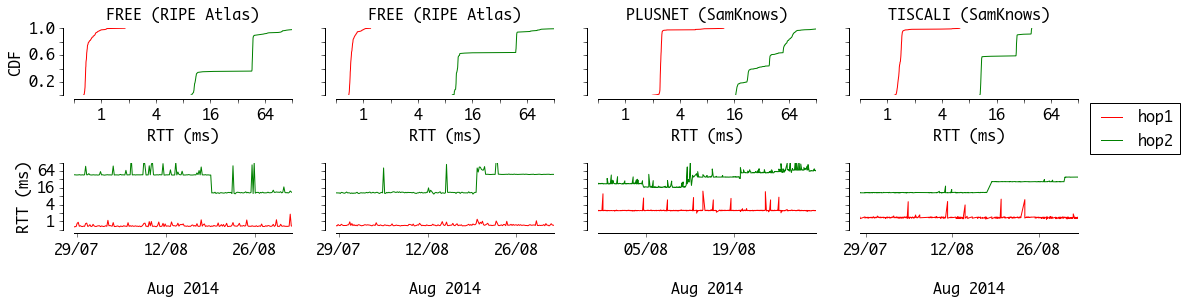

In [47]:
fig, ((ax1, ax2, ax3, ax4), (bx1, bx2, bx3, bx4)) = plt.subplots(2, 4, sharey='row')
fig.set_size_inches(18, 4)
fs = 15
plt.rcParams['font.size'] = fs

probeid = 17225
start_cdf(df_ra, probeid, ax1, platform = 'RIPE Atlas', fs = 15)

probeid = 16717
start_cdf(df_ra, probeid, ax2, platform = 'RIPE Atlas', fs = 15)

probeid = 202398
start_cdf(df_sk, probeid, ax3, platform = 'SamKnows', fs = 15)

probeid = 148550
start_cdf(df_sk, probeid, ax4, platform = 'SamKnows', fs = 15)

ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()
ax4.legend_.remove()

#ax1.set_xlabel('')
#ax2.set_xlabel('')
#ax3.set_xlabel('')
#ax4.set_xlabel('')

ax2.set_ylabel('', fontsize=22)
ax3.set_ylabel('', fontsize=22)
ax4.set_ylabel('', fontsize=22)

yticks      = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]        
yticklabels = ['', '0.2', '', '0.6', '', '1.0']         
ax1.set_yticks(yticks, yticks)   
ax1.set_yticklabels(yticklabels)

yticklabels = ax2.get_yticklabels() + ax3.get_yticklabels() + ax4.get_yticklabels()
plt.setp(yticklabels, visible=False)

probeid = 17225
start_timeseries(df_ra, probeid, bx1, platform = 'RIPE Atlas', fs = 15)

probeid = 16717
start_timeseries(df_ra, probeid, bx2, platform = 'RIPE Atlas', fs = 15)

probeid = 202398
start_timeseries(df_sk, probeid, bx3, platform = 'SamKnows', fs = 15)

probeid = 148550
start_timeseries(df_sk, probeid, bx4, platform = 'SamKnows', fs = 15)

yticklabels = bx2.get_yticklabels() + bx3.get_yticklabels() + bx4.get_yticklabels()
plt.setp(yticklabels, visible=False)

bx1.legend_.remove()
bx2.legend_.remove()
bx3.legend_.remove()
bx4.legend(['hop1', 'hop2'], fontsize=fs, loc='best', bbox_to_anchor=(-0.8, -1.2), ncol=2)
bx4.legend(['hop1', 'hop2'], fontsize=fs, loc='best', bbox_to_anchor=(1.5, 2), ncol=1)

bx1.set_title('')
bx2.set_title('')
bx3.set_title('')
bx4.set_title('')

#bx1.set_xlabel('')
#bx2.set_xlabel('')
#bx3.set_xlabel('')
#bx4.set_xlabel('')

fig.subplots_adjust(hspace = 1)
plt.savefig('interleaving.pdf', format='pdf', bbox_inches='tight')